# 1. Model

使用的zhipuai 免费的model做的实验
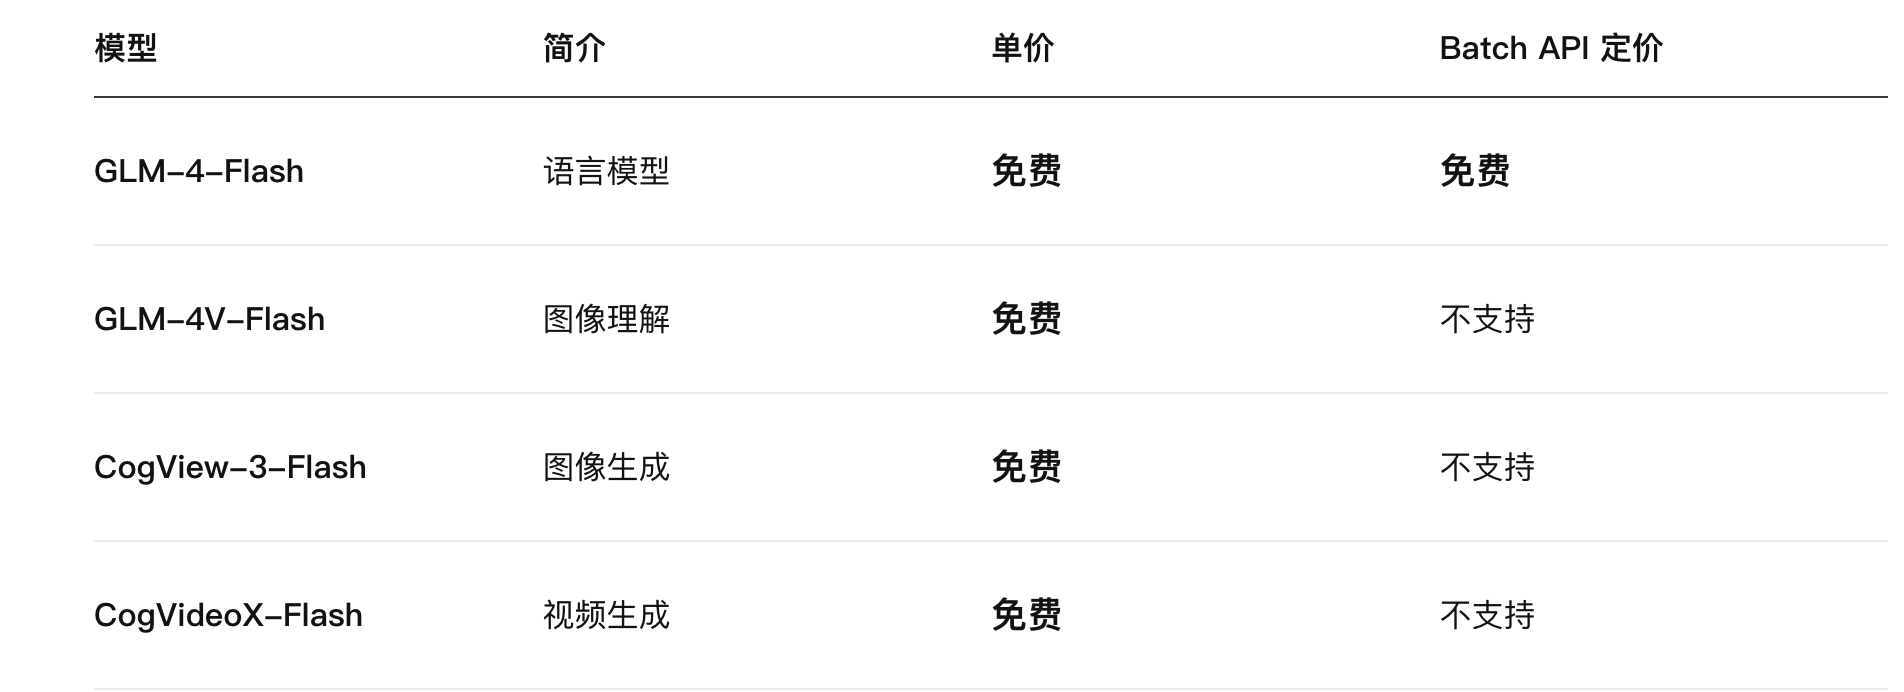

>环境：python 3.10.16

```sh
# 1.
conda create -n autogen_envs python=3.10.16

# 2.
pip install -U "autogen-agentchat" "autogen-ext[openai]"

# 3.
pip install langchain langchain_community langchain_ollama langchain_experimental
```

>后面少什么自己 pip 安装什么, 不导 requirements.txt 了


### 1. OpenAI格式的 SDK

In [1]:
from autogen_ext.models.openai import OpenAIChatCompletionClient
from dotenv import load_dotenv
import os

load_dotenv()
api_keys = os.getenv("API_KEY")
# Create an agent that uses the OpenAI GPT-4o model.
model_client = OpenAIChatCompletionClient(
            model="glm-4-flash",
            api_key=api_keys,
            base_url="https://open.bigmodel.cn/api/paas/v4/",
            model_info={
                "vision": False,
                "function_calling": True,
                "json_output": True,
                "family": "glm",
            },
            temperature=0.7,
            top_p=0.95,
            max_tokens=2048
        )

# 2.Message
[AutoGen -> Message](https://microsoft.github.io/autogen/stable/user-guide/agentchat-user-guide/tutorial/messages.html)

## Agent与Agent间的消息

### 1. 文本消息

```python
from autogen_agentchat.messages import TextMessage
```

In [2]:
from autogen_agentchat.messages import TextMessage

# 创建一条文本消息, 接受一个字符串内容和一个字符串源
text_message = TextMessage(content="Hello, world!", source="User")

### 2. 多模态消息
```python
from autogen_agentchat.messages import MultiModalMessage
```


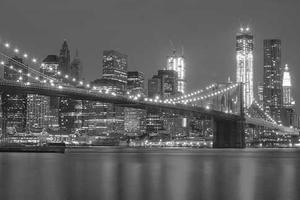

In [3]:
from io import BytesIO

import requests
from autogen_agentchat.messages import MultiModalMessage
from autogen_core import Image as AGImage
from PIL import Image

pil_image = Image.open(BytesIO(requests.get("https://picsum.photos/300/200").content))
img = AGImage(pil_image)
multi_modal_message = MultiModalMessage(content=["Can you describe the content of this image?", img], source="User")
img

# 3. Agent

[AutoGen -> Agent](https://microsoft.github.io/autogen/stable/user-guide/agentchat-user-guide/tutorial/agents.html)

### 1) Assistant Agent

```python
from autogen_agentchat.agents import AssistantAgent
```

In [4]:
from autogen_agentchat.agents import AssistantAgent
from autogen_agentchat.messages import TextMessage
from autogen_agentchat.ui import Console
from autogen_core import CancellationToken
from autogen_ext.models.openai import OpenAIChatCompletionClient
from dotenv import load_dotenv
import os


In [5]:
# Define a tool that searches the web for information.
async def web_search(query: str) -> str:
    """Find information on the web"""
    return "AutoGen is a programming framework for building multi-agent applications."


agent = AssistantAgent(
    name="assistant",
    model_client=model_client,
    tools=[web_search],
    system_message="Use tools to solve tasks.",
)

### 2) Getting Response


`on_message`  返回 一个 `Response` 包含 `inner_messages` 和 `chat_message` 两个属性


- `inner_messages`: 内部消息列表，存储里最终响应 agent 的 “思考过程”

- `chat_message`: agent 的最终响应



In [6]:
async def assistant_run() -> None:
    response = await agent.on_messages(
        [TextMessage(content="Find information on AutoGen", source="user")],
        cancellation_token=CancellationToken(),
    )
    print(response.inner_messages)
    print('\n' + '#' * 50 + '\n')
    print(response.chat_message)


# Use asyncio.run(assistant_run()) when running in a script.
await assistant_run()

[ToolCallRequestEvent(source='assistant', models_usage=RequestUsage(prompt_tokens=124, completion_tokens=14), content=[FunctionCall(id='call_-8929810368167993179', arguments='{"query": "What is AutoGen?"}', name='web_search')], type='ToolCallRequestEvent'), ToolCallExecutionEvent(source='assistant', models_usage=None, content=[FunctionExecutionResult(content='AutoGen is a programming framework for building multi-agent applications.', call_id='call_-8929810368167993179', is_error=False)], type='ToolCallExecutionEvent')]

##################################################

source='assistant' models_usage=None content='AutoGen is a programming framework for building multi-agent applications.' type='ToolCallSummaryMessage'


### 3) Multi-Modal Input


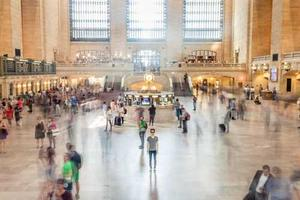

In [7]:
from io import BytesIO

import PIL
import requests
from autogen_agentchat.messages import MultiModalMessage
from autogen_core import Image

vision_model_client = OpenAIChatCompletionClient(
            model="glm-4v-flash",
            api_key=api_keys,
            base_url="https://open.bigmodel.cn/api/paas/v4/",
            model_info={
                "vision": True,
                "function_calling": True,
                "json_output": False,
                "family": "glm",
            }
        )

# Create a multi-modal message with random image and text.
pil_image = PIL.Image.open(BytesIO(requests.get("https://picsum.photos/300/200").content))
img = Image(pil_image)
multi_modal_message = MultiModalMessage(content=["Can you describe the content of this image?", img], source="user")
img

In [8]:
# 因为之前的 agent 是 glm-4-flash, 不支持图片识别
vision_agent = AssistantAgent(
    name="vision",
    model_client=vision_model_client,
    tools=[web_search],
    system_message="Use tools to solve tasks.",
)
# Use asyncio.run(...) when running in a script.
response = await vision_agent.on_messages([multi_modal_message], CancellationToken())
print(response.chat_message.content)

The image depicts a large, bustling interior space that appears to be a train station or similar public building. The architecture features high ceilings and large windows with intricate designs. There are many people walking through the area, which gives a sense of movement and activity. The lighting is warm, creating an inviting atmosphere. In the background, there's a central area with seating and possibly a clock or decorative feature above it. The overall scene suggests a busy transit hub like Grand Central Terminal in New York City.


### 4) Streaming Messages

`on_message_stream`


打印到控制台 `Console`

`from autogen_agentchat.ui import Console` 


最后一项信息是 `chat_message` 属性中的响应消息 

In [9]:
async def assistant_run_stream() -> None:
    # Option 1: read each message from the stream (as shown in the previous example).
    # async for message in agent.on_messages_stream(
    #     [TextMessage(content="Find information on AutoGen", source="user")],
    #     cancellation_token=CancellationToken(),
    # ):
    #     print(message)

    # Option 2: use Console to print all messages as they appear.
    await Console(
        agent.on_messages_stream(   # 可以试试 vision_agent
            [TextMessage(content="Find information on AutoGen", source="user")],
            cancellation_token=CancellationToken(),
        ),
        output_stats=True,  # Enable stats printing.
    )


# Use asyncio.run(assistant_run_stream()) when running in a script.
await assistant_run_stream()

---------- assistant ----------
[FunctionCall(id='call_-8929807103991840713', arguments='{"query": "What is AutoGen?"}', name='web_search')]
[Prompt tokens: 159, Completion tokens: 14]
---------- assistant ----------
[FunctionExecutionResult(content='AutoGen is a programming framework for building multi-agent applications.', call_id='call_-8929807103991840713', is_error=False)]
---------- assistant ----------
AutoGen is a programming framework for building multi-agent applications.
---------- Summary ----------
Number of inner messages: 2
Total prompt tokens: 159
Total completion tokens: 14
Duration: 6.60 seconds


### 5）Using Tools

在 1) AssistantAgent 中，我们定义了一个 `web_search` 工具 (演示例子)

```python
agent = AssistantAgent(
    name="assistant",
    model_client=model_client,
    tools=[web_search],
    system_message="Use tools to solve tasks.",
)
```

**如果工具未以自然语言返回格式正确的字符串**，在`AssistantAgent`构造函数中设置`reflect_on_tool_use=True`参数。

### 6）langchain Tools

除了自定义 Tools，还可以通过将 Langchain 库中的工具包装在 `LangChainToolAdapter` 中来使用它们

>glm-4-flash 毕竟免费，有时候会算不出来，多试几次，用API是真爽，本地部署太麻烦了

In [11]:
import pandas as pd
from autogen_ext.tools.langchain import LangChainToolAdapter
from langchain_experimental.tools.python.tool import PythonAstREPLTool

df = pd.read_csv("https://raw.githubusercontent.com/pandas-dev/pandas/main/doc/data/titanic.csv")

# LangChainToolAdapter
tool = LangChainToolAdapter(PythonAstREPLTool(locals={"df": df}))

agent = AssistantAgent(
    "assistant", tools=[tool], model_client=model_client, system_message="Use the `df` variable to access the dataset."
)

await Console(
    agent.on_messages_stream(
        [TextMessage(content="What's the average age of the passengers?", source="user")], CancellationToken()
    ),
    output_stats=True,
)

---------- assistant ----------
[FunctionCall(id='call_-8929801228474686924', arguments='{"query": "df[\'Age\'].mean()"}', name='python_repl_ast')]
[Prompt tokens: 177, Completion tokens: 56]
---------- assistant ----------
[FunctionExecutionResult(content='29.69911764705882', call_id='call_-8929801228474686924', is_error=False)]
---------- assistant ----------
29.69911764705882
---------- Summary ----------
Number of inner messages: 2
Total prompt tokens: 177
Total completion tokens: 56
Duration: 1.62 seconds


Response(chat_message=ToolCallSummaryMessage(source='assistant', models_usage=None, content='29.69911764705882', type='ToolCallSummaryMessage'), inner_messages=[ToolCallRequestEvent(source='assistant', models_usage=RequestUsage(prompt_tokens=177, completion_tokens=56), content=[FunctionCall(id='call_-8929801228474686924', arguments='{"query": "df[\'Age\'].mean()"}', name='python_repl_ast')], type='ToolCallRequestEvent'), ToolCallExecutionEvent(source='assistant', models_usage=None, content=[FunctionExecutionResult(content='29.69911764705882', call_id='call_-8929801228474686924', is_error=False)], type='ToolCallExecutionEvent')])